# Fit SNPE to all the successful simulations on **any** morphology that Arco's genetic algorithm has produced
### Code runs on `split-simulate-and-train` branch of `sbi`
As soon as its merged, it will run on `main`.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

import pandas as pd
import torch
import numpy as np

from parameter_setup import load_ground_truth_params, load_prior_max, load_prior_min
from sbi.inference import SNPE, prepare_for_sbi
from sbi.utils import BoxUniform, pairplot, posterior_nn

In [3]:
def drop_columns(data_pd):
    data_no_ss = data_pd.drop(
        columns=[
            "BAC_APheight",
            "BAC_ISI",
            "BAC_ahpdepth",
            "BAC_caSpike_height",
            "BAC_caSpike_width",
            "BAC_spikecount",
            "bAP_APheight",
            "bAP_APwidth",
            "bAP_att2",
            "bAP_att3",
            "bAP_spikecount",
        ]
    )
    data_only_params = data_no_ss.drop(
        columns=[
            "model_id",
            "type_",
            "morphology",
            "lv",
            "seed",
            "max_",
            "gen",
            "hot_zone.outsidescale_sections",
            "morphology.filename",
            "BAC.stim.dist",
            "hot_zone.max_",
            "bAP.hay_measure.recSite2",
            "bAP.hay_measure.recSite1",
            "hot_zone.min_",
            "BAC.hay_measure.recSite",
            "sort_column",
        ]
    )
    return data_only_params

In [4]:
data1 = pd.read_pickle(
    "../../../arco_sims/all_simulations_from_GA/selected_BAC_1.pickle"
)

In [71]:
theta1 = drop_columns(data1)
data1 = 0.0

In [72]:
theta = theta1.to_numpy()  # pd.concat((theta1, theta2, theta3))
theta1 = 0.0

In [327]:
data2 = pd.read_pickle(
    "../../../arco_sims/all_simulations_from_GA/selected_BAC_2.pickle"
)
theta2 = drop_columns(data2)
data2 = 0.0

In [75]:
theta = np.concatenate((theta, theta2.to_numpy()))  # pd.concat((theta1, theta2, theta3))
theta2 = 0.0

In [328]:
data3 = pd.read_pickle(
    "../../../arco_sims/all_simulations_from_GA/selected_BAC_3.pickle"
)
theta3 = drop_columns(data3)
data3 = 0.0
theta = np.concatenate((theta, theta3.to_numpy()))  # pd.concat((theta1, theta2, theta3))
theta3 = 0.0

In [86]:
np.random.shuffle(theta)

In [87]:
theta.shape

(9000000, 35)

from pyknos.nflows import distributions as distributions_
from pyknos.nflows import flows, transforms
from pyknos.nflows.nn import nets
from torch import Tensor, nn, relu, tanh

from sbi.utils.sbiutils import standardizing_net, standardizing_transform
from sbi.utils.torchutils import create_alternating_binary_mask
### Define hyperparameters for inference

In [88]:
num_datapoints = 3000000
num_hiddens = 100
num_transforms = 5
training_batch_size = 200
max_num_epochs = 300
stop_after_epochs = 30
num_bins = 20

### Define ingredients for SNPE

In [89]:
prior = BoxUniform(torch.as_tensor(load_prior_min()), torch.as_tensor(load_prior_max()))

In [90]:
net_builder = posterior_nn(
    "nsf",
    z_score_theta=True,
    z_score_x=False,
    hidden_features=num_hiddens,
    num_transforms=num_transforms,
    num_bins_nsf=num_bins
)

In [98]:
theta_train = torch.as_tensor(theta[:num_datapoints], dtype=torch.float32)
x = torch.ones(theta_train.shape[0], 5)
print("Number of training points: ", theta_train.shape[0])

Number of training points:  3000000


### Plot prior samples

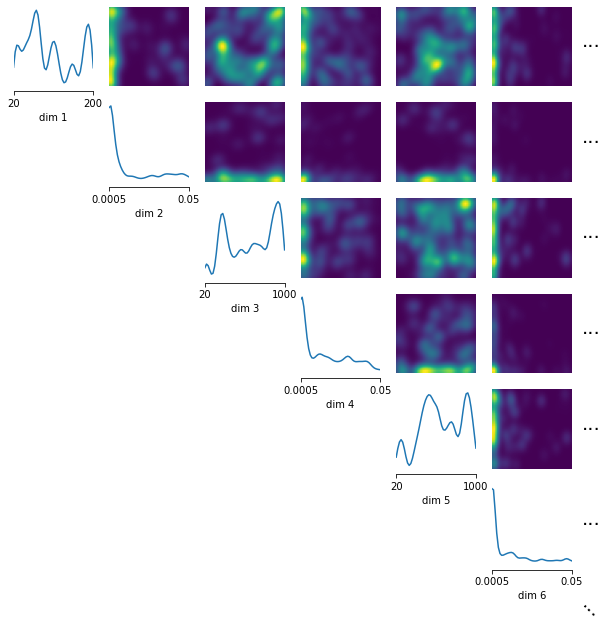

In [99]:
limits = np.asarray([load_prior_min(), load_prior_max()])
_ = pairplot(theta_train[:10000], subset=[0,1,2,3,4,5], limits=limits.T, ticks=limits.T, upper='kde', diag='kde')

### Set up SNPE

In [100]:
inference = SNPE(prior, density_estimator=net_builder)

In [101]:
inference = inference.append_simulations(theta_train, x, proposal=None)

In [102]:
_ = torch.manual_seed(0)
density_estimator = inference.train(
    training_batch_size=training_batch_size,
    max_num_epochs=max_num_epochs,
    stop_after_epochs=stop_after_epochs,
)

Number of bins: 20
Neural network successfully converged after 153 epochs.


In [103]:
posterior = inference.build_posterior().set_default_x(torch.ones(1, 5))

In [105]:
_ = torch.manual_seed(0)
samples = posterior.sample((10_000,))

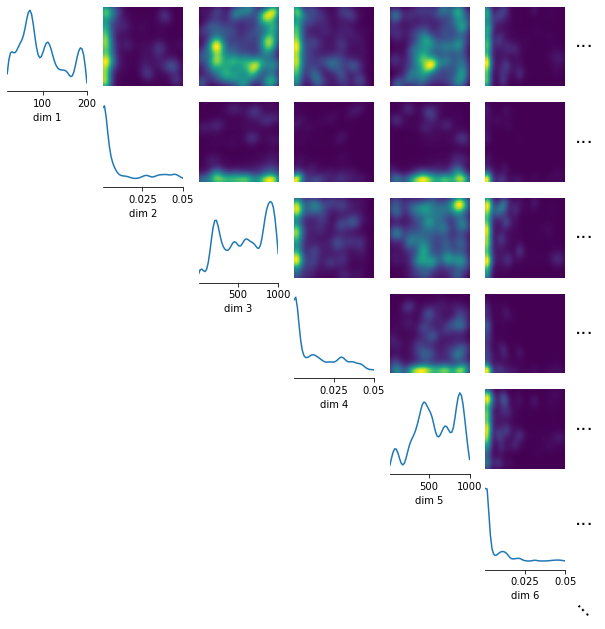

In [106]:
limits = np.asarray([load_prior_min(), load_prior_max()])
_ = pairplot(samples, subset=[0, 1, 2, 3, 4, 5], limits=limits.T, upper='kde', diag='kde')

In [312]:
# import pickle
# with open('../results/samples/201123_SNPE_300epochs_GA_data_bigger_net_training_data.pickle', 'wb') as handle:
#     pickle.dump(theta_train.detach().numpy(), handle, protocol=2)

In [107]:
# import pickle
# with open('../results/samples/201123_SNPE_300epochs_GA_data_bigger_net.pickle', 'wb') as handle:
#     pickle.dump(samples.detach().numpy(), handle, protocol=2)

In [104]:
# import pickle
# with open('../results/samples/201123_SNPE_300epochs_GA_data_bigger_net_posterior.pickle', 'wb') as handle:
#     pickle.dump(posterior, handle, protocol=2)

### Obtaining the support

In [274]:
class posterior_support:
    def __init__(self, posterior, prior, num_samples_to_estimate_support: int = 50_000):
        samples = posterior.sample((num_samples_to_estimate_support,))
        log_probs = posterior.log_prob(samples)
        self.thr = torch.min(log_probs)
        print('self.thr', self.thr)
        self.thr = torch.tensor([10.0])

    def sample(self, sample_shape: torch.Size):
        """
        Sample from the posterior support.

        This is done by sampling from the prior and accepting samples only if
        their posterior-log-probability is larger than some threshold. The
        threshold is chosen to be the minimum log-prob of 50_000 posterior
        samples (see `num_samples_to_estimate_support` in `__init__()`).
        """
        all_accepted = []
        num_samples = torch.Size(sample_shape).numel()
        num_remaining = num_samples
        total_drawn = 0
        while num_remaining > 0:
            num_to_draw = torch.max(torch.tensor([num_remaining]), torch.tensor([10_000]))
            prior_samples = prior.sample((num_to_draw,))
            posterior_log_probs = posterior.log_prob(prior_samples)
            accepted_samples = prior_samples[posterior_log_probs > self.thr]
            all_accepted.append(accepted_samples)
            num_remaining -= accepted_samples.shape[0]
            total_drawn += num_to_draw
        print("Accepted", torch.cat(all_accepted).shape[0], 'samples out of', total_drawn, 'candidate samples.')
        frac = torch.as_tensor(torch.cat(all_accepted).shape[0], dtype=torch.float32)/total_drawn
        print("The fraction of accepted samples is: ", frac)
        print("The speed-up is:  ", 1/frac)
        return torch.cat(all_accepted)[:num_samples]

    def log_prob():
        raise NotImplementedError

In [275]:
# Then, after the first round is finished, you can do.
proposal = posterior_support(posterior, prior, num_samples_to_estimate_support=10_000)


self.thr tensor(128.3928)


In [276]:
_ = torch.manual_seed(1)
support_theta = proposal.sample((1_000,))

Accepted 1002 samples out of tensor([470000]) candidate samples.
The fraction of accepted samples is:  tensor([0.0021])
The speed-up is:   tensor([469.0619])


In [277]:
_ = torch.manual_seed(0)
support_theta = proposal.sample((10_000,))

Accepted 10007 samples out of tensor([4740000]) candidate samples.
The fraction of accepted samples is:  tensor([0.0021])
The speed-up is:   tensor([473.6685])


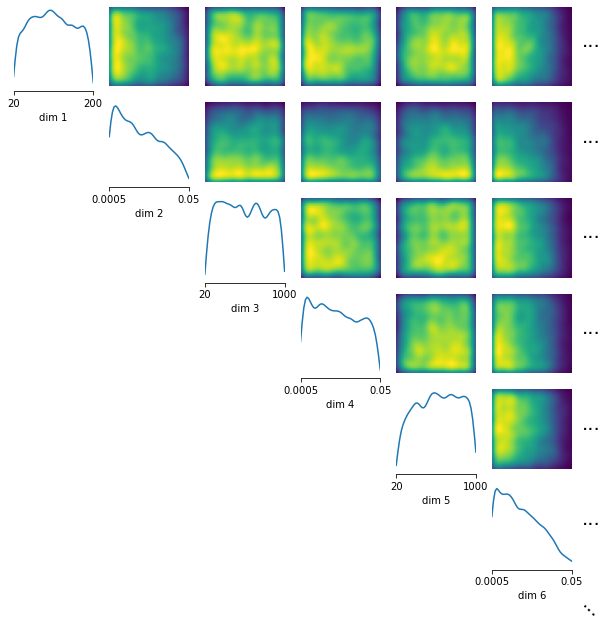

In [145]:
limits = np.asarray([load_prior_min(), load_prior_max()])
_ = pairplot(support_theta, subset=[0,1,2,3,4,5], limits=limits.T, ticks=limits.T, upper='kde', diag='kde')

In [155]:
# with open('../results/samples/201123_SNPE_300epochs_GA_data_bigger_net_posterior.pickle', 'rb') as handle:
#     posterior_new = pickle.load(handle)

### Plot a histogramm of prior sample log_probs and density log_probs

In [224]:
import matplotlib.pyplot as plt

In [291]:
theta_test = torch.as_tensor(theta[num_datapoints:num_datapoints+300000], dtype=torch.float32)

In [204]:
prior_lp = posterior.log_prob(prior.sample((10000,)))
gt_lp = posterior_new.log_prob(theta_test[:10000])

In [205]:
torch.min(gt_lp)

tensor(15.5560)

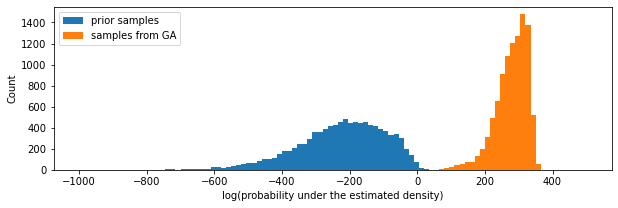

In [206]:
fig, ax = plt.subplots(1,1,figsize=(10,3))
priorhist = ax.hist(prior_lp.unsqueeze(1).numpy(), range=[-1000, 500], bins=100)
posthist = ax.hist(gt_lp.unsqueeze(1).numpy(), range=[-1000, 500], bins=100)
ax.set_xlabel("log(probability under the estimated density)")
ax.set_ylabel("Count")
ax.legend(["prior samples", "samples from GA"])

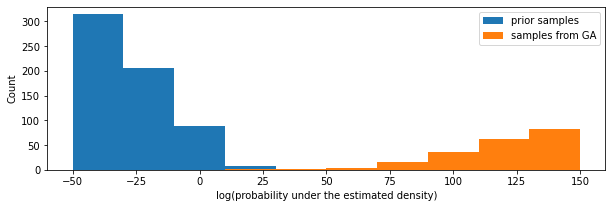

In [207]:
fig, ax = plt.subplots(1,1,figsize=(10,3))
priorhist = ax.hist(prior_lp.unsqueeze(1).numpy(), range=[-50, 150], bins=10)
posthist = ax.hist(gt_lp.unsqueeze(1).numpy(), range=[-50, 150], bins=10)
ax.set_xlabel("log(probability under the estimated density)")
ax.set_ylabel("Count")
ax.legend(["prior samples", "samples from GA"])

In [292]:
more_gt_lp = posterior_new.log_prob(theta_test[:300000])

In [295]:
sorted_gt_lp, _ = torch.sort(more_gt_lp)

zero_percent = sorted_gt_lp[int(0.0*(sorted_gt_lp.shape[0]))]
print(zero_percent)

pointzeroone_percent = sorted_gt_lp[int(0.0001*(sorted_gt_lp.shape[0]))]
print(pointzeroone_percent)

pointone_percent = sorted_gt_lp[int(0.001*(sorted_gt_lp.shape[0]))]
print(pointone_percent)

one_percent = sorted_gt_lp[int(0.01*(sorted_gt_lp.shape[0]))]
print(one_percent)

tensor(-4.7912)
tensor(39.6355)
tensor(76.5995)
tensor(125.4237)


Text(0, 0.5, 'Count')

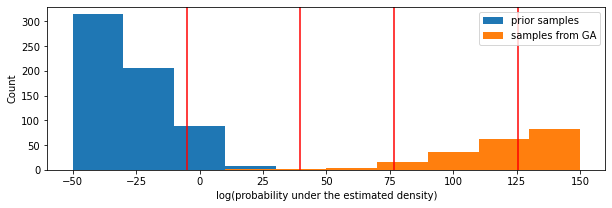

In [296]:
fig, ax = plt.subplots(1,1,figsize=(10,3))
priorhist = ax.hist(prior_lp.unsqueeze(1).numpy(), range=[-50, 150], bins=10)
posthist = ax.hist(gt_lp.unsqueeze(1).numpy(), range=[-50, 150], bins=10)
ax.legend(["prior samples", "samples from GA"])
line1 = ax.axvline(zero_percent, color='r')
line2 = ax.axvline(pointzeroone_percent, color='r')
line3 = ax.axvline(pointone_percent, color='r')
line4 = ax.axvline(one_percent, color='r')
ax.set_xlabel("log(probability under the estimated density)")
ax.set_ylabel("Count")

Text(0, 0.5, 'Count')

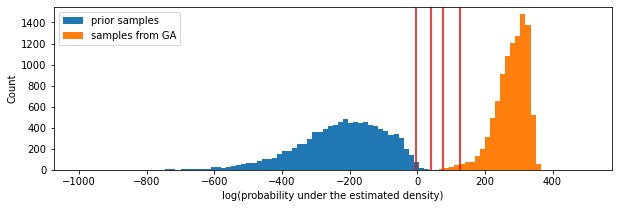

In [297]:
fig, ax = plt.subplots(1,1,figsize=(10,3))
priorhist = ax.hist(prior_lp.unsqueeze(1).numpy(), range=[-1000, 500], bins=100)
posthist = ax.hist(gt_lp.unsqueeze(1).numpy(), range=[-1000, 500], bins=100)
ax.legend(["prior samples", "samples from GA"])
line1 = ax.axvline(zero_percent, color='r')
line2 = ax.axvline(pointzeroone_percent, color='r')
line3 = ax.axvline(pointone_percent, color='r')
line4 = ax.axvline(one_percent, color='r')
ax.set_xlabel("log(probability under the estimated density)")
ax.set_ylabel("Count")

### Get estimates for the rejection rate

In [308]:
class posterior_support_tryout:
    def __init__(self, posterior, prior, num_samples_to_estimate_support: int = 50_000):
        samples = posterior.sample((num_samples_to_estimate_support,))
        log_probs = posterior.log_prob(samples)
        self.thr = torch.min(log_probs)

    def sample(self, sample_shape: torch.Size):
        """
        Sample from the posterior support.

        This is done by sampling from the prior and accepting samples only if
        their posterior-log-probability is larger than some threshold. The
        threshold is chosen to be the minimum log-prob of 50_000 posterior
        samples (see `num_samples_to_estimate_support` in `__init__()`).
        """
        all_accepted = []
        num_samples = torch.Size(sample_shape).numel()
        num_remaining = num_samples
        total_drawn = 0
        num_iterations = 0
        while num_remaining > 0 and total_drawn < 5e7:
            print("New iter", num_iterations)
            num_to_draw = torch.max(torch.tensor([num_remaining]), torch.tensor([100_000]))
            prior_samples = prior.sample((num_to_draw,))
            posterior_log_probs = posterior.log_prob(prior_samples)
            accepted_samples = prior_samples[posterior_log_probs > self.thr]
            all_accepted.append(accepted_samples)
            num_remaining -= accepted_samples.shape[0]
            total_drawn += num_to_draw
            num_iterations += 1
        print("Accepted", torch.cat(all_accepted).shape[0], 'samples out of', total_drawn, 'candidate samples.')
        frac = torch.as_tensor(torch.cat(all_accepted).shape[0], dtype=torch.float32)/total_drawn
        print("The fraction of accepted samples is: ", frac)
        print("The speed-up is:  ", 1/frac)
        return torch.cat(all_accepted)[:num_samples]

    def log_prob():
        raise NotImplementedError

In [309]:
# Then, after the first round is finished, you can do.
proposal_tryout = posterior_support_tryout(posterior, prior, num_samples_to_estimate_support=1_000)
proposal_tryout.thr = zero_percent

In [310]:
_ = torch.manual_seed(0)
support_theta_tryout = proposal_tryout.sample((10_000,))

New iter 0
New iter 1
New iter 2
New iter 3
New iter 4
New iter 5
New iter 6
New iter 7
New iter 8
New iter 9
New iter 10
New iter 11
New iter 12
New iter 13
Accepted 10730 samples out of tensor([1400000]) candidate samples.
The fraction of accepted samples is:  tensor([0.0077])
The speed-up is:   tensor([130.4753])


In [311]:
# Then, after the first round is finished, you can do.
proposal_tryout = posterior_support_tryout(posterior, prior, num_samples_to_estimate_support=1_000)
proposal_tryout.thr = pointzeroone_percent
_ = torch.manual_seed(0)
support_theta_tryout_pointzeroone = proposal_tryout.sample((10_000,))


New iter 0
New iter 1
New iter 2
New iter 3
New iter 4
New iter 5
New iter 6
New iter 7
New iter 8
New iter 9
New iter 10
New iter 11
New iter 12
New iter 13
New iter 14
New iter 15
New iter 16
New iter 17
New iter 18
New iter 19
New iter 20
New iter 21
New iter 22
New iter 23
New iter 24
New iter 25
New iter 26
New iter 27
New iter 28
New iter 29
New iter 30
New iter 31
New iter 32
New iter 33
New iter 34
New iter 35
New iter 36
New iter 37
New iter 38
New iter 39
New iter 40
New iter 41
New iter 42
New iter 43
New iter 44
New iter 45
New iter 46
New iter 47
New iter 48
New iter 49
New iter 50
New iter 51
New iter 52
New iter 53
New iter 54
New iter 55
New iter 56
New iter 57
New iter 58
New iter 59
New iter 60
New iter 61
New iter 62
New iter 63
New iter 64
New iter 65
New iter 66
New iter 67
New iter 68
New iter 69
New iter 70
New iter 71
New iter 72
New iter 73
New iter 74
New iter 75
New iter 76
New iter 77
New iter 78
New iter 79
New iter 80
New iter 81
New iter 82
New iter 83
N

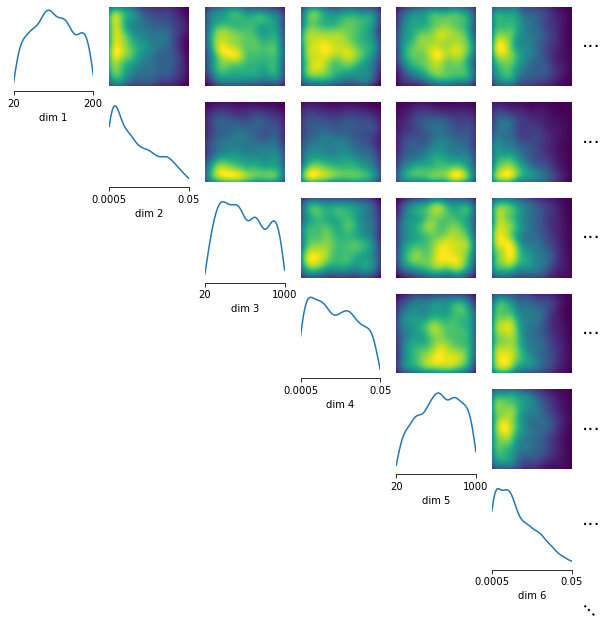

In [314]:
limits = np.asarray([load_prior_min(), load_prior_max()])
_ = pairplot(support_theta_tryout_pointzeroone, subset=[0,1,2,3,4,5], limits=limits.T, ticks=limits.T, upper='kde', diag='kde')

In [313]:
import pickle
with open('../results/samples/201123_SNPE_300epochs_GA_data_bigger_net_samples_from_support_pointonepercentquantile.pickle', 'wb') as handle:
    pickle.dump(support_theta_tryout_pointzeroone.detach().numpy(), handle, protocol=2)

In [ ]:
limits = np.asarray([load_prior_min(), load_prior_max()])
_ = pairplot(support_theta, subset=[0,1,2,3,4,5], limits=limits.T, ticks=limits.T, upper='kde', diag='kde')

In [300]:
pointzeroone_percent

tensor(39.6355)

### Plot histograms over samples drawn from the estimated density

In [191]:
prior_lp = posterior.log_prob(prior.sample((10000,)))
posterior_lp = posterior_new.log_prob(posterior.sample((10000,)))

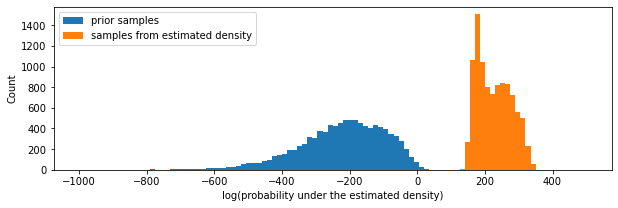

In [192]:
fig, ax = plt.subplots(1,1,figsize=(10,3))
priorhist = ax.hist(prior_lp.unsqueeze(1).numpy(), range=[-1000, 500], bins=100)
posthist = ax.hist(posterior_lp.unsqueeze(1).numpy(), range=[-1000, 500], bins=100)
ax.set_xlabel("log(probability under the estimated density)")
ax.set_ylabel("Count")
ax.legend(["prior samples", "samples from estimated density"])

In [149]:
# import pickle
# with open('../results/samples/201123_SNPE_300epochs_GA_data_bigger_net_supportsamples.pickle', 'wb') as handle:
#     pickle.dump(support_theta.detach().numpy(), handle, protocol=2)